In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from schedulers import LinearScheduler,CosineScheduler
from unet import UNetTimed, UNetTimedWithVAE
from schedulers import DDPM
from schedulers import DDIMSampler
from vae import VAE




mnist_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


In [2]:
vae_model = VAE(latent_dim=64)
vae_model.load_state_dict(torch.load('vae_model.pth'))
vae_model.eval()

for param in vae_model.parameters():
    param.requires_grad = False

unet = UNetTimedWithVAE(vae_model)

# vae_model.encoder(torch.randn(1, 1, 28, 28))
# unet(torch.randn(1, 1, 28, 28), torch.randint(0, 1000, (1,)))


/tmp/ipykernel_120823/1731143756.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('vae_model.pth'))


In [3]:
# latent_image = unet.encode_vae(torch.randn(1, 1, 28, 28))
# denoised_image = unet(latent_image, torch.randint(0, 1000, (1,)))

# unet.decode_vae(denoised_image)

In [ ]:
# Create DataLoader
batch_size = 128
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer and loss function
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
mse_loss = torch.nn.MSELoss()

# Training hyperparameters
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)

# DDPM instance
ddpm = DDPM(0.001, 0.2, 1000)

num_steps = 200

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        
        # For reflow, we use:
        # x1: the real (clean) image from the dataset
        # x0: a noise sample from a standard Gaussian (e.g., N(0, I))
        x1 = images
        x0 = torch.randn_like(images).to(device)
        
        # The target constant velocity is: v_target = (x1 - x0)
        target_velocity = x1 - x0
        
        loss = 0
        # Loop over discrete time steps t in [0, 1]
        # (Here, torch.linspace generates num_steps values between 0 and 1)
        for t in torch.linspace(0, 1, num_steps, device=device):
            # Compute the linear interpolation along the "ideal" path:
            xt = (1 - t) * x0 + t * x1
            
            # The network predicts a velocity given state xt and time t.
            # We want this prediction to match the constant target velocity.
            v_pred = unet(xt, t)  # Ensure your UNet accepts a scalar t (or embeds it)
            
            # Accumulate the squared error between the predicted and target velocity:
            loss += torch.norm(v_pred - target_velocity, p=2) ** 2
        
        # Average the loss over the time steps:
        loss = loss / num_steps
        
        # Backpropagation and optimizer update:
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch} | Average Loss: {avg_loss:.4f}')
    
    # Optional: Save checkpoint
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'latent_ddpm_checkpoint_epoch_{epoch+1}.pt')

last torch.Size([128, 1, 8, 8])
Epoch 0 | Batch 0 | Loss: 1.9762
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last torch.Size([128, 1, 8, 8])
last to

KeyboardInterrupt: 

last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last torch.Size([16, 1, 8, 8])
last tor

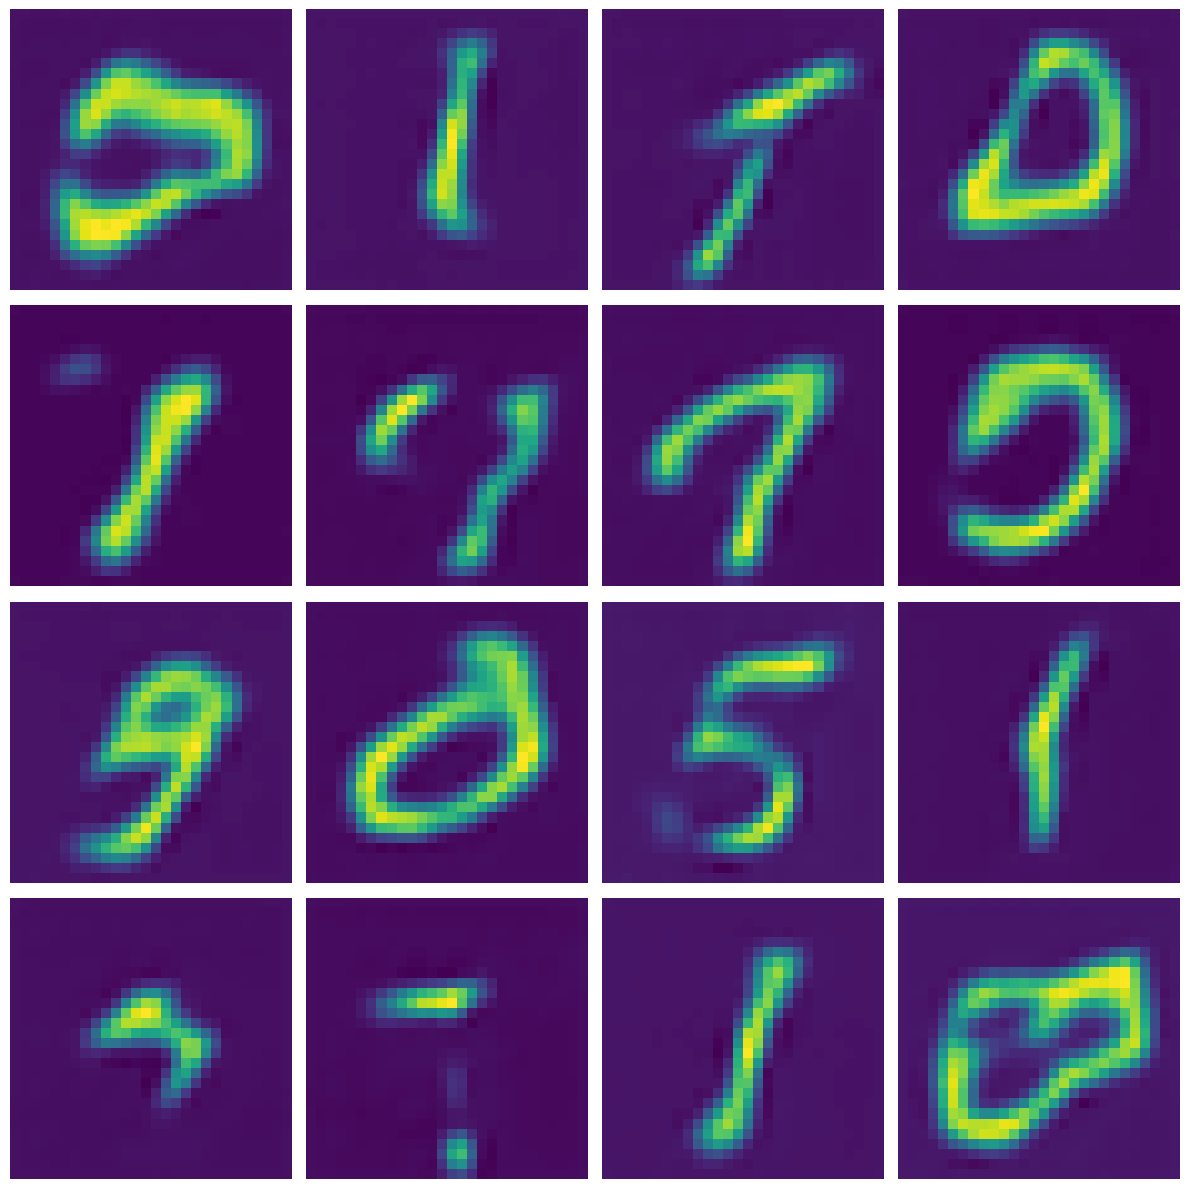

In [12]:
sampler = DDIMSampler(0.001, 0.2, 1000)
sampled_latent_images = sampler.sample(
    model=unet,
    n_samples=16,
    img_size=(1, 8, 8),  # For MNIST
    device=device,
    steps=100 # Can use fewer steps than training
)


# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = unet.decode_vae(sampled_latent_images[i]).cpu().numpy()[0,0]
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()